<a href="https://colab.research.google.com/github/Vinooj/kaggle-competition/blob/main/Ames_Housing_Price_Prediction_Kick_starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Research findings on how to tackle this problem: https://docs.google.com/document/d/1cQ9JuvhWk9c-moFPzfNjFl9qOZ5sJeuw74pBhjazHVA

## CHANGE LOG,
This notebook has been updated to include a local validation and scoring mechanism to mimic the Kaggle evaluation process. Here are the key changes:

**🚦 Development Mode Switch**: A new `DEVELOPMENT_MODE` flag is introduced.
- If `True`, the notebook splits `train.csv` into a new training
  and validation set. This allows for local scoring against a known hold-out set.
- If `False`, the notebook uses the original `train.csv` and `test.csv` to generate a final submission file for Kaggle.

** bölünmüş Data Splitting for Validation**: When in `DEVELOPMENT_MODE`, the code now uses `train_test_split` to create a hold-out validation set. The true sale prices for this set are saved to `solution.csv` to act as the ground truth for scoring.

**📈 Integrated Scoring Workflow**: The modeling section has been restructured. For each model configuration, the notebook now automatically:\n,
- Calls `generate_submission_file` to train the model and save its predictions.
- Calls `get_kaggle_score` to evaluate the predictions against the local `solution.csv` and prints a Kaggle-like score.
- Calls `plot_scatter` to visualize the performance on the validation set.

**🛠️ Bug Fixes & Cleanup**: Corrected a syntax error in the `GradientBoostingRegressor` definition and removed redundant code to improve clarity and ensure the script runs smoothly.
   

In [1]:
# ==============================================================================
# Cell 0: Configuration
# ==============================================================================

# --- Development Mode Switch ---
# Set to True to split train.csv into a new train/validation set for local testing.
# Set to False to use the full train.csv and original test.csv for final submission.
DEVELOPMENT_MODE = True

In [4]:
!pip install scikit-learn~=1.6.0 mlxtend -q
!pip install import-ipynb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 81.0 MB/s eta 0:00:00


In [5]:
# ==============================================================================
# Cell 1: Setup and Imports
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm
from scipy.special import boxcox1p
import import_ipynb

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# For stacking
from mlxtend.regressor import StackingCVRegressor

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set some options for pandas and plotting
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("Libraries imported successfully.")

Libraries imported successfully.


In [6]:
# ==============================================================================
# Cell 2: UTILITY SCRIPTS
# ==============================================================================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_scatter(plot_title, actual_values, predicted_values):
    """
    Generates a scatter plot comparing actual vs. predicted values.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    plt.plot([actual_values.min(), actual_values.max()],
             [actual_values.min(), actual_values.max()], 'k--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(plot_title)
    plt.grid(True)
    plt.show()

def generate_submission_file(model, model_name, X_train, y_train, X_test, test_ids):
    """
    Trains a model, predicts on test data, and saves to a submission CSV.
    """
    print(f"--- Generating submission for model: {model_name} ---")

    # 1. Train the model on the provided training data.
    print("Training model...")
    model.fit(X_train, y_train)

    # 2. Make predictions (these will be on the log scale).
    print("Making predictions...")
    test_predictions_log = model.predict(X_test)

    # 3. Revert the log transformation using expm1 for numerical stability.
    test_predictions = np.expm1(test_predictions_log)

    # 4. Create and save the submission DataFrame.
    submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': test_predictions})
    filename = f"submission_{model_name}.csv"
    submission_df.to_csv(filename, index=False)

    print(f"Submission file created successfully at: {filename}\n")
    return filename, test_predictions

def get_kaggle_score(submission_filepath, solution_filepath):
    """
    Scores a submission file against the solution file using RMSLE.
    """
    try:
        submission_df = pd.read_csv(submission_filepath)
        solution_df = pd.read_csv(solution_filepath)
    except FileNotFoundError as e:
        print(f"Error: {e}. Make sure both files exist.")
        return None

    merged_df = pd.merge(submission_df, solution_df, on='Id', how='inner', suffixes=('_pred', '_true'))

    if len(merged_df) != len(solution_df):
        print("Warning: Submission file is missing some IDs from the solution file.")

    # Calculate RMSE on the log-transformed values, which is equivalent to RMSLE.
    y_pred_log = np.log1p(merged_df['SalePrice_pred'])
    y_true_log = np.log1p(merged_df['SalePrice_true'])

    score = rmse(y_true_log, y_pred_log)

    print(f"--- Scoring Report for: {submission_filepath} ---")
    print(f"Kaggle-like Score (RMSLE): {score:.5f}")
    return score

In [7]:
# ==============================================================================
# Cell 3: Data Loading and Splitting
# ==============================================================================

# Load the full original training data
full_train_df = pd.read_csv('./sample_data/train.csv')
kaggle_test_df = pd.read_csv('./sample_data/test.csv')

if DEVELOPMENT_MODE:
    print("--- Running in DEVELOPMENT MODE ---")
    # Split the original training data into a new training set and a validation set
    train_df, val_df = train_test_split(full_train_df, test_size=0.2, random_state=42)

    # The validation set will act as our 'test' set for local scoring
    test_df = val_df.drop('SalePrice', axis=1)

    # Save the true prices of the validation set to a solution file
    solution_df = pd.DataFrame({'Id': val_df['Id'], 'SalePrice': val_df['SalePrice']})
    solution_df.to_csv('solution.csv', index=False)
    y_val_untransformed = val_df['SalePrice'] # Keep for plotting

    print(f"Original train data split into: ")
    print(f"  New training set: {train_df.shape[0]} rows")
    print(f"  Validation set:   {test_df.shape[0]} rows")
    print("Solution file 'solution.csv' created for local scoring.")

else:
    print("--- Running in PRODUCTION MODE ---")
    # Use the original full training and test sets for final submission
    train_df = full_train_df
    test_df = kaggle_test_df
    print(f"Using full training set ({train_df.shape[0]} rows) and Kaggle test set ({test_df.shape[0]} rows).")

# Save IDs for submission file, then drop from main dataframes
train_id = train_df['Id']
test_id = test_df['Id']
train_df.drop("Id", axis=1, inplace=True)
test_df.drop("Id", axis=1, inplace=True)

--- Running in DEVELOPMENT MODE ---
Original train data split into: 
  New training set: 1168 rows
  Validation set:   292 rows
Solution file 'solution.csv' created for local scoring.


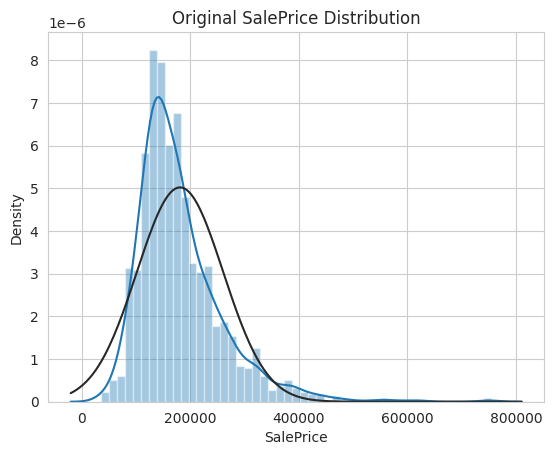

Skewness of original SalePrice: 1.74


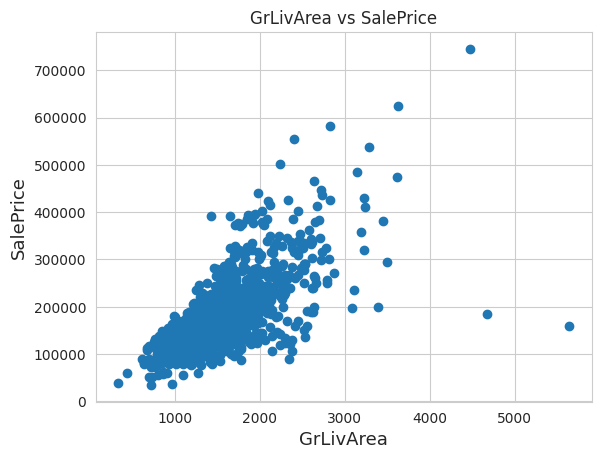

Outliers removed. New train set shape: (1166, 80)


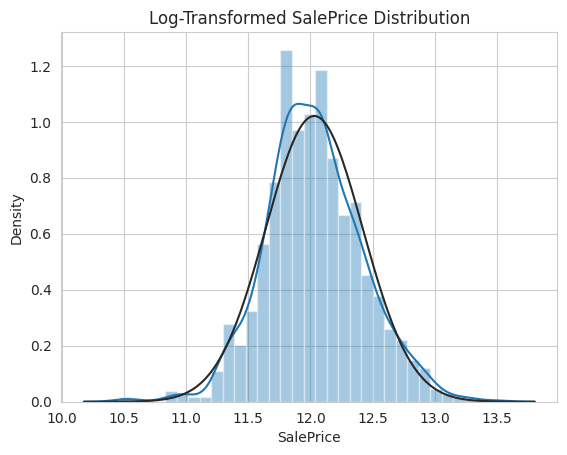

Combined dataset shape for preprocessing: (1458, 79)
Remaining missing values after imputation: 0


In [8]:
# ==============================================================================
# Cell 4: Data Cleaning and Preparation
# ==============================================================================
# --- Visualizing the original target variable distribution ---
sns.distplot(full_train_df['SalePrice'], fit=norm)
plt.title('Original SalePrice Distribution')
plt.show()
print(f"Skewness of original SalePrice: {train_df['SalePrice'].skew():.2f}")

# --- Surgical Outlier Handling ---
# Based on scatter plot, remove two specific outliers in GrLivArea from the training set
plt.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title("GrLivArea vs SalePrice")
plt.show()

train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
print(f"Outliers removed. New train set shape: {train_df.shape}")

# --- Target Variable Transformation (Log Transform) ---
y_train = np.log1p(train_df['SalePrice'])
train_df.drop('SalePrice', axis=1, inplace=True)

sns.distplot(y_train, fit=norm)
plt.title('Log-Transformed SalePrice Distribution')
plt.show()

n_train = train_df.shape[0]

# --- Combine for Preprocessing and Impute Missing Data ---
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
print(f"Combined dataset shape for preprocessing: {all_data.shape}")

# Impute features where NaN means "None"
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

# Impute features where NaN means 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

# Impute LotFrontage with the median of its neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Impute categorical features with the mode
for col in ('MSZoning', 'Electrical', 'Utilities', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Functional: data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

print(f"Remaining missing values after imputation: {all_data.isnull().sum().sum()}")

In [9]:
# ==============================================================================
# Cell 5: Feature Engineering
# ==============================================================================

# Create holistic features
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBaths'] = all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath'])
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']

# Create temporal features
all_data['AgeOfHouse'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['YearsSinceRemodel'] = all_data['YrSold'] - all_data['YearRemodAdd']

# Create interaction and polynomial features
all_data['OverallQual_sq'] = all_data['OverallQual']**2
all_data['GrLivArea_sq'] = all_data['GrLivArea']**2
all_data['OverallQual_x_GrLivArea'] = all_data['OverallQual'] * all_data['GrLivArea']

print("Feature engineering complete.")

Feature engineering complete.


In [13]:
# =============================================================================
# Cell 6: Skewness Correction, Encoding, and Scaling
# =============================================================================
# --- Correcting Skewed Numerical Features ---
numeric_feats = all_data.dtypes[all_data.dtypes!= "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
skewed_features = skewed_feats.index

for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], 0.15) # Box-Cox transform

print(f"{len(skewed_features)} skewed numerical features transformed.")

# --- One-Hot Encoding Categorical Variables ---
final_data = pd.get_dummies(all_data).reset_index(drop=True)
print(f"Categorical features one-hot encoded. Final data shape: {final_data.shape}")

# --- Separate train and test sets again ---
X_train = final_data[:n_train]
X_test = final_data[n_train:]

# Align columns - crucial for when dev mode creates different columns than prod mode
train_cols = X_train.columns
test_cols = X_test.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train[c] = 0

X_test = X_test[train_cols] # Ensure order is the same

# ==============================================================================
# === NEWLY ADDED SCALING STEP ===
# We scale the data here to avoid pipeline issues with mlxtend's StackingCVRegressor.
# This converts the DataFrames to NumPy arrays for the models.
# ==============================================================================
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data successfully scaled.")
print(f"Final training features shape: {X_train.shape}")
print(f"Final test features shape: {X_test.shape}")

11 skewed numerical features transformed.
Categorical features one-hot encoded. Final data shape: (1458, 309)
Data successfully scaled.
Final training features shape: (1166, 309)
Final test features shape: (292, 309)


### Explanation of Regularization
The formula for the cost function with L2 regularization is:
$$J(\vec{w}, b) = \frac{1}{2m} \sum_{i=1}^{m} (f_{\vec{w},b}(\vec{x}^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m} \sum_{j=1}^{n} w_j^2$$
This cost function balances two goals:
1.  **Accuracy (Mean Squared Error)**: The first term, $\frac{1}{2m} \sum_{i=1}^{m} (f_{\vec{w},b}(\vec{x}^{(i)}) - y^{(i)})^2$, measures the average squared difference between the predicted and actual values. Minimizing this term makes the model more accurate.
2.  **Simplicity (Regularization Term)**: The second term, $\frac{\lambda}{2m} \sum_{j=1}^{n} w_j^2$, is a penalty for model complexity. It penalizes large values for the model parameters ($w_j$).
    - The parameter **`λ` (lambda)** controls the strength of the penalty. A higher `λ` forces the model parameters to be smaller, leading to a simpler model that is less likely to overfit.
    - In scikit-learn and other libraries, this is controlled by parameters like `alpha` (for Ridge, Lasso) or `reg_lambda` (for XGBoost, LightGBM).

In [19]:
# =============================================================================
# Cell 7: Model Definitions and Robust Manual Stacking Implementation
# =============================================================================
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.impute import SimpleImputer
import numpy as np

# --- Base Models ---
# The models are defined as before.
ridge = Ridge(alpha=10.0, random_state=42)
lasso = Lasso(alpha=0.0005, random_state=42)
elastic_net = ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10,
                                loss='huber', random_state=42,
                                subsample=0.8)
lgbm = LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05,
                       n_estimators=720, max_bin=55, bagging_fraction=0.8,
                       bagging_freq=5, feature_fraction=0.2319, feature_fraction_seed=9,
                       bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11,
                       random_state=42, verbose=-1)
xgbr = XGBRegressor(learning_rate=0.05, n_estimators=2200, max_depth=3,
                      min_child_weight=0, gamma=0, subsample=0.7,
                      colsample_bytree=0.7, reg_alpha=0.005, nthread=-1,
                      scale_pos_weight=1, seed=42, random_state=42)

# --- Robust Manual Stacking Regressor ---
# This corrected version handles NaN predictions from base models and ensures
# proper training for both the meta-model and final predictions.
class ManualStackingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.base_models_ = []
        self.meta_model_ = None
        self.imputer_ = None

    def fit(self, X, y):
        # 1. Train final base models on the entire dataset for later use in .predict()
        self.base_models_ = [clone(model).fit(X, y) for model in self.base_models]

        # 2. Generate out-of-fold predictions to train the meta-model
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))

        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # --- ROBUSTNESS FIX ---
        # 3. Impute any NaNs produced by unstable base models.
        self.imputer_ = SimpleImputer(strategy='mean')
        level_one_features = self.imputer_.fit_transform(out_of_fold_predictions)

        # 4. Train the meta-model on the cleaned level-one features
        self.meta_model_ = clone(self.meta_model)
        self.meta_model_.fit(level_one_features, y)

        return self

    def predict(self, X):
        # 1. Get predictions from the final base models
        level_one_features = np.column_stack([model.predict(X) for model in self.base_models_])

        # 2. Impute NaNs using the imputer that was fitted on the training data
        level_one_features = self.imputer_.transform(level_one_features)

        # 3. Make the final prediction using the meta-model
        return self.meta_model_.predict(level_one_features)

print("Base models and Robust ManualStackingRegressor class defined successfully.")

Base models and Robust ManualStackingRegressor class defined successfully.


--- Training Manual Stack (Full) ---
--- Training Individual Models for Blending ---

Submission file created at: submission_blended_ensemble.csv
--- Scoring Report for: submission_blended_ensemble.csv ---
Kaggle-like Score (RMSLE): 0.12343


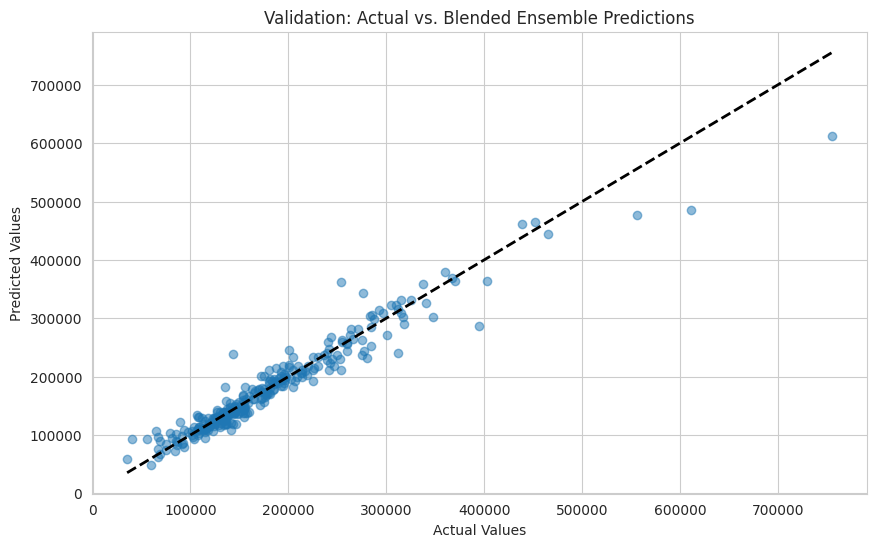

In [20]:
# =============================================================================
# Cell 8: Model Training, Prediction, and Evaluation (with Manual Stacking)
# =============================================================================

# Define the models for stacking using our new manual regressor
base_models_tuple = (ridge, lasso, elastic_net, gbr, xgbr, lgbm)
manual_stack = ManualStackingRegressor(base_models=base_models_tuple, meta_model=lasso)


# --- Experiment 1: Full Ensemble (Stacked + Blended) ---
print("--- Training Manual Stack (Full) ---")
manual_stack.fit(X_train, y_train.values)
stack_pred_log = manual_stack.predict(X_test)

print("--- Training Individual Models for Blending ---")
xgbr.fit(X_train, y_train.values)
xgb_pred_log = xgbr.predict(X_test)

lgbm.fit(X_train, y_train.values)
lgbm_pred_log = lgbm.predict(X_test)

# Blend predictions (on the log scale)
ensemble_pred_log = (0.70 * stack_pred_log) + (0.15 * xgb_pred_log) + (0.15 * lgbm_pred_log)
ensemble_pred = np.expm1(ensemble_pred_log)

# Save submission file for the blended model
submission_df_blend = pd.DataFrame({'Id': test_id, 'SalePrice': ensemble_pred})
submission_filename_blend = 'submission_blended_ensemble.csv'
submission_df_blend.to_csv(submission_filename_blend, index=False)
print(f"\nSubmission file created at: {submission_filename_blend}")

# In dev mode, score the result and plot it
if DEVELOPMENT_MODE:
    get_kaggle_score(submission_filename_blend, 'solution.csv')
    plot_scatter("Validation: Actual vs. Blended Ensemble Predictions", y_val_untransformed, ensemble_pred)